In [1]:
# 统计一阶邻居分类个数
import dgl
import os 
from multiprocessing import Pool
import pickle
import numpy as np

[15:56:45] Using backend: pytorch
/opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: libtorch_cuda_cpp.so: cannot open shared object file: No such file or directory


In [2]:
base_path='./dataset'
graphs, _ = dgl.load_graphs(os.path.join(base_path, 'graph.bin'))
graph = graphs[0]
# graph = dgl.add_self_loop(graph) # 去除否则会采到自己的标签

In [3]:
with open(os.path.join(base_path, 'k_fold_labels.pkl'), 'rb') as f:
    label_data = pickle.load(f)
    labels = label_data['label']
    test_label_idx = label_data['test_label_idx']

In [4]:
test_num = 2000
# test_num = graphs[0].num_nodes()
nids = range(test_num)

In [66]:
def count_map(nid):
    g_out = dgl.sampling.sample_neighbors(graph, [nid], -1, edge_dir='out')
    g_in = dgl.sampling.sample_neighbors(graph, [nid], -1, edge_dir='in')
    src_out, dst_out = g_out.all_edges()
    src_in, dst_in = g_in.all_edges()
    in_labs = labels[src_in].reshape((-1))
    out_labs = labels[dst_out].reshape((-1))
    
    count_in = np.zeros(24)
    count_out = np.zeros(24)
    for i in in_labs:
        if i == -1:
            count_in[23]+=1
        else:
            count_in[i]+=1
    for i in out_labs:
        if i == -1:
            count_out[23]+=1
        else:
            count_out[i]+=1
    return [count_in, count_out]

In [67]:
count_map(10)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 6.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 15.])]

In [1]:
result = []
for nid in nids:
    result.append(count_map(nid))
result = np.array(result)
np.save(os.path.join(base_path, 'neighbors_class_count.npy'), result)
result.shape

NameError: name 'nids' is not defined

In [5]:
import pandas as pd
import numpy as np
base_path='./dataset'
result = np.load(os.path.join(base_path, 'neighbors_class_count.npy'))
result.shape

(3655452, 2, 24)

In [6]:
import pickle
with open(os.path.join(base_path, 'k_fold_labels.pkl'), 'rb') as f:
    label_data = pickle.load(f)
    labels = label_data['label']
labels.shape

(3655452,)

In [7]:
# 无标签点个数
np.sum(labels==-1)

2611035

In [8]:
edge_num = np.sum(result.reshape((-1,48)), axis=-1) # 每个点的边的个数
class_edge_num = np.sum(result[:,:,:23].reshape((-1,46)), axis=-1) # 每个点有标签的边的个数
edge_num.shape, class_edge_num.shape

((3655452,), (3655452,))

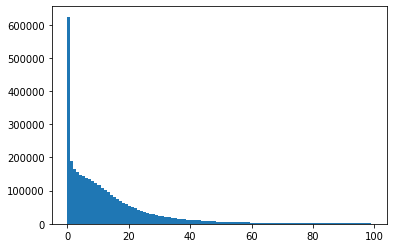

In [9]:
import matplotlib.pyplot as plt
plt.hist(edge_num[edge_num<100], bins=100)
plt.show()

In [10]:
# 6w点没有边
np.sum(edge_num==0)

624085

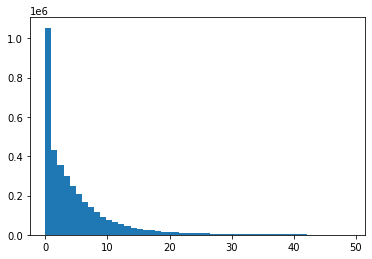

In [11]:
plt.hist(class_edge_num[class_edge_num<50], bins=50)
plt.show()

In [12]:
# 100w点周围没有分类标签
np.sum(class_edge_num==0)

1054265

In [13]:
# 自己没有标签 但是周围有标签的
# 260w自己没标签其中174W周围有标签
c1 = labels==-1
c2 = class_edge_num!=0
c3 = c1*c2
np.sum(c1), np.sum(c3)

(2611035, 1741613)

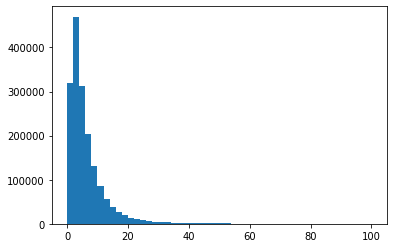

In [14]:
plt.hist(class_edge_num[c3], bins=50, range=(0, 100))
plt.show()

In [15]:
# 标签率
class_rate = class_edge_num/(edge_num+0.1)

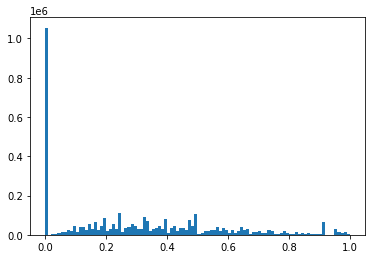

In [16]:
plt.hist(class_rate, bins=100)
plt.show()

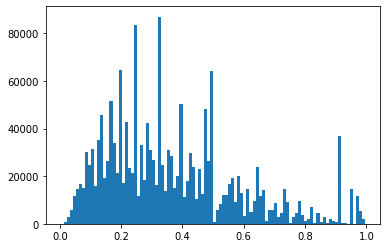

In [17]:
# 260w自己没标签其中174W周围有标签的标签率
plt.hist(class_rate[c3], bins=100)
plt.show()

In [18]:
# 260w自己没标签其中的174W周围有标签, 174w周围标签中最大标签数站总标签数的比例
label_count = np.sum(result[:,:,:23],-2)
label_count.shape

(3655452, 23)

In [19]:
max_num_label_rate = np.max(label_count,axis=-1)/(np.sum(label_count,axis=-1)+0.1)

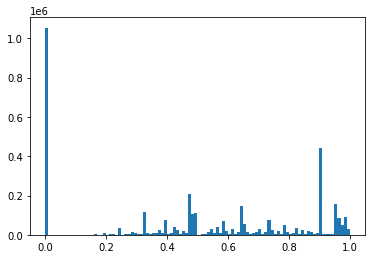

In [20]:
# 周围标签中，最多个数的标签占比总标签的比例
plt.hist(max_num_label_rate, bins=100)
plt.show()

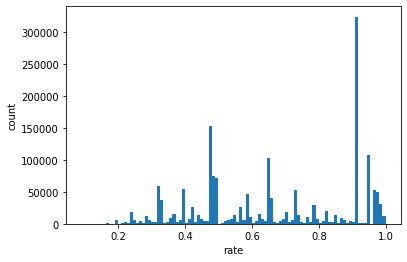

In [21]:
# 260w点自己没标签其中的174W周围有标签,  174w周围标签中个数最多的标签（除去无标签）占总标签数（除去无标签）的比例
plt.hist(max_num_label_rate[c3], bins=100)
plt.xlabel('rate')
plt.ylabel('count')
plt.show()

In [22]:
max_num_label_all_rate = np.max(label_count,axis=-1)/(edge_num+0.1)

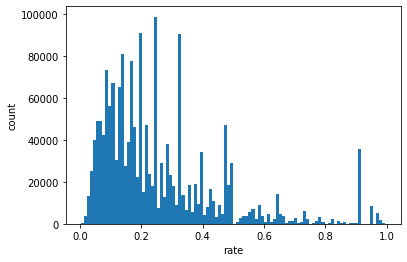

In [23]:
# 260w点自己没标签其中的174W周围有标签, 174w周围标签中个数最多的标签（除去无标签）占总边数的比例
plt.hist(max_num_label_all_rate[c3], bins=100)
plt.xlabel('rate')
plt.ylabel('count')
plt.show()

In [24]:
label_all_rate = np.sum(label_count,axis=-1)/(edge_num+0.1)

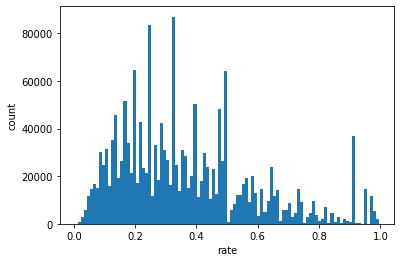

In [25]:
# 260w点自己没标签其中的174W周围有标签, 174w周围标签总数占总边数的比例
plt.hist(label_all_rate[c3], bins=100)
plt.xlabel('rate')
plt.ylabel('count')
plt.show()

In [26]:
np.sum(max_num_label_all_rate[c3]>0.5)

150160

In [27]:
c4 = np.zeros(labels.shape)
c4[test_label_idx] = 1
c4 = np.array(c4, dtype=np.bool)

In [28]:
c5 = c4*c3

In [29]:
test_max_num_label_rate = max_num_label_all_rate[c5]

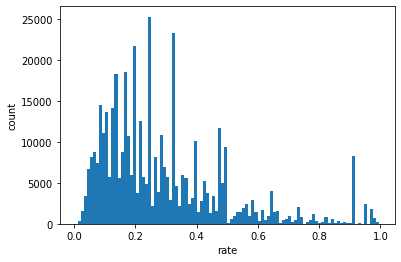

In [30]:
plt.hist(test_max_num_label_rate, bins=100)
plt.xlabel('rate')
plt.ylabel('count')
plt.show()

In [31]:
np.sum(test_max_num_label_rate>0.3)

160509

In [32]:
def id2name(x):
    return chr(x + 65)

In [33]:
import pandas as pd
se_predict = pd.read_csv('dataset/se_16.csv')

In [34]:
se_predict.head()

,id,label
0,c39457cc34fa969b03819eaa4f9b7a52,D
1,668b9d0c53e9b6e2c6b1093102f976b3,P
2,ca5c7bc1b40c0ef3c3f864aed032ca90,B
3,44f810c0c000cda27ce618add55e815f,H
4,3c206335d88637d36d83c2942586be98,K


In [35]:
c6 = max_num_label_all_rate>0.3
c7 = c6*c4

In [36]:
test_label_idx[:10]

array([3063061, 3063062, 3063063, 3063064, 3063065, 3063066, 3063067,
       3063068, 3063069, 3063070])

In [37]:
n_id = np.argwhere(c7)
n_id.shape

(160509, 1)

In [38]:
max_class = np.argmax(label_count, axis=-1)
max_class[:10]

array([ 0, 12,  1,  0,  7,  3,  0, 19,  5,  7])

In [39]:

se_label = se_predict['label'].to_list()
se_label[:10]

['D', 'P', 'B', 'H', 'K', 'D', 'D', 'D', 'N', 'N']

In [51]:
def id2name(x):
    return chr(x + 65)

new_se_label = []
for index, label in enumerate(se_label):
    n_id = test_label_idx[index]
    if max_num_label_all_rate[n_id]>0.8:
        new_se_label.append(id2name(max_class[n_id]))
    else:
        new_se_label.append(label)

In [52]:
is_not_same = np.array(new_se_label)!=np.array(se_label)
np.sum(is_not_same)

2141

In [53]:
se_predict['label'] = new_se_label
se_predict.to_csv('dataset/new_se_predict0.8.csv')

In [54]:
se_predict.head()

,id,label
0,c39457cc34fa969b03819eaa4f9b7a52,D
1,668b9d0c53e9b6e2c6b1093102f976b3,P
2,ca5c7bc1b40c0ef3c3f864aed032ca90,B
3,44f810c0c000cda27ce618add55e815f,H
4,3c206335d88637d36d83c2942586be98,K


In [45]:
se_predict

,id,label
0,c39457cc34fa969b03819eaa4f9b7a52,D
1,668b9d0c53e9b6e2c6b1093102f976b3,P
2,ca5c7bc1b40c0ef3c3f864aed032ca90,B
3,44f810c0c000cda27ce618add55e815f,H
4,3c206335d88637d36d83c2942586be98,K
...,...,...
592386,ce9f6a2278633a2dd47838b5e62e15f1,J
592387,caed47d55d1e193ecb1fa97a415c13dd,B
592388,c82eb6be79a245392fb626b9a7e1f246,M
592389,926a31f6b378575204aae30b5dfa6dd3,W
